# **anaCalo**

In [1]:
# set %matplotlib inline (%matplotlib widget, %matplotlib qt) for static (interactive on-page, interactive in separate window) plots
# in order to use the on-page interactive mode, make sure the environment is set up properly
# comment this out before exporting the notebook to a Python script -- via jupyter nbconvert --to script anaKrys.ipynb
%matplotlib inline

# external modules
import os
import importlib
import succolib as sl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import pandas as pd
from scipy.optimize import curve_fit

# internal modules (in .modules), shared with anaKrys
from modules import *

---

## **data input settings**

In [2]:
# test mode controller: if True (False), the software runs with test (custom, selected via settingsFileMods) settings and data
boolTest = False

# label of the settings fileset to load -- useless if boolTest=True
settingsFileMods = "y22StormCernH2"

# file type, either "ASCII" or "ROOT"
filetype = "ASCII"

# file name structure
# list of XXXXXX (run nrs.) to be set below
# will cycle on all available YYYYYY (file nrs.)
filename = "/eos/user/m/msoldani/succo/phd_nocloud/data_local/22_cern_h2_storm/ascii_merged/runXXXXXX_YYYYYY.dat"

# calorimeter name (like in dictionary z, e.g. caloFwd)
# by default, this sticks to the convention of having the first letter lowercase (uppercase) when standalone (with a prefix, e.g. in digiPHRawCaloFwd)
name_cal = "caloFwd"

# names of Si layers for tracking, ((hor0, hor1), (ver0, ver1))
ind_track = (("0", "2"), ("1", "3"))

# names of other Si layers in the calo. path (not for tracking, just for single-hit event selection), (x0, x1, ...)
# can be left empty
ind_layers_1hit = ()

# list of runs for equalisation, {ch: XXXXXX}
# these keys will also be used as list calo. channels to involve (ind_calo)
runs_eq = {
    "CaloFwdBL" : "520140",
    "CaloFwdBR" : "520139",
    "CaloFwdCL" : "520142",
    "CaloFwdCC" : "520126",
    "CaloFwdCR" : "520127",
    "CaloFwdTL" : "520141",
    "CaloFwdTR" : "520138",
}

# list of energies for calibration
ls_calib_energies = (120, 100, 80, 60, 20)  # 40,

# list of runs for calibration, 1 per energy, in the same order as in ls_calib_energies, {calorimeter: (run0, run1, ...)}
ls_calib_runs = {
    "caloFwd": ("520124", "520151", "520150", "520126", "520144"),  # "520132", 
}

---

## **load external settings & data input**
#### to dataframe ```df```

In [3]:
runs_calib = dict(zip(ls_calib_energies, ls_calib_runs[name_cal]))

In [4]:
# import settings, according to boolTest and settingsFileMods
# function in .modules --> set ./settings/__init__.py for settings fileset selection
mod_runList_name, mod_settings_name = settingsSelect(boolTest, whichInput = filetype if boolTest else settingsFileMods)
globals().update(importlib.import_module(mod_runList_name).__dict__)
globals().update(importlib.import_module(mod_settings_name).__dict__)

# print only (functions in .modules)
boolControlPrint(True, boolTest, filetype)

looking for files with label y22StormCernH2 in ./settings/
execution control booleans:
data reload controller: True
test mode controller: False


In [5]:
# base names for Si data variables, i.e. positions and nrs. of hit
var_x = "xRaw"
var_nhit = "nHit"

# base names for calo. data variables, i.e. PHs and times
var_ph = "digiPHRaw"
var_time = "digiTime"

In [6]:
ind_calo = list(runs_eq.keys())  # list of calo. channel names

# list of variables to be extracted from raw data
ls_vars = ["iRun"]
ls_vars += ["typeRun"]
ls_vars += [var_x+s for i in range(2) for s in ind_track[i]]
ls_vars += [var_nhit+s for i in range(2) for s in ind_track[i]]
ls_vars += [var_nhit+s for s in ind_layers_1hit]
ls_vars += [var_ph+s for s in ind_calo]
ls_vars += [var_time+s for s in ind_calo]

# list of all runs to be opened
runs_all = list()
for ch in runs_eq:
    runs_all.append(runs_eq[ch])
runs_all += list(runs_calib.values())

# open data files and set dataframe up
df, dt = loadGeneral(filetype, filename, {s: nRun0[s] for s in runs_all}, {}, mirrorMap, globals(), False)
# df = df[list(set(ls_vars))]

opening ASCII files... --> data into DataFrame df
progressbars won't be visualized...
(1/11) 520124 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(2/11) 520126 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(3/11) 520127 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(4/11) 520138 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(5/11) 520139 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(6/11) 520140 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(7/11) 520141 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(8/11) 520142 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(9/11) 520144 -- descaling fraction: 1.000000000000
no variables to mirror
iRun also added to df
(10/11) 520150 -- descaling fraction: 1.0

---

## **tracking**

#### **settings here:**

In [7]:
# initial settings
ch_tracking = ("calib", 120, "CaloFwdCC")  # data to be used for tracking, ("eq"/"calib", energy, ch)
# note: if "eq" is selected, energy is not used
# note: if "calib" is selected, ch is not used to select a run but it is used to select a channel to cut on
ch_tracking_thresh = (200, 20000)  # threshold on PH to highlight calo. channel, for plots with single, selected channel
xcalo_range = ((-2, 4), (-2, 4))  # range of beam spot single-channel 2d histograms, ((left, right), (lower, upper))

# resulting cuts, to be set here for plotting purposes
ang_cut_eq = (500, 500)  # cuts on input angles (wt. distibution weighted average) in urad, for equalisation, (hor, ver)
fid_eq = ((0, 2), (0, 2))  # fiducial box @ calorimeter plane, for equalisation, ((hor0, hor1), (ver0, ver1))
ls_calib_angles = (  # cuts on input angles (wrt. distibution weighted average) in urad, for calibration, per energy (same order as in ls_calib_energies), (hor, ver)
    (500, 500),  # nominal energy: 120
    (500, 500),
    (500, 500),
    (500, 500),
    (500, 500),
    (500, 500),
)
ls_calib_fid = {  # fiducial box @ calorimeter plane, for calibration, per energy (same order as in ls_calib_energies), {calorimeter: ((hor0, hor1), (ver0, ver1))}
    "caloFwd": (
        ((-0.5, 2.5), (-0.5, 2.5)),  # nominal energy: 120
        ((-0.5, 2.5), (-0.5, 2.5)),
        ((-0.5, 2.5), (-0.5, 2.5)),
        ((-0.5, 2.5), (-0.5, 2.5)),
        ((-0.5, 2.5), (-0.5, 2.5)),
        ((-0.5, 2.5), (-0.5, 2.5)),
    ),
}

In [8]:
ang_cut_calib = dict(zip(ls_calib_energies, ls_calib_angles))
fid_calib = dict(zip(ls_calib_energies, ls_calib_fid[name_cal]))

In [9]:
# create necessary booleans
b_run_tr = df.iRun==runs_eq[ch_tracking[2]] if ch_tracking[0]=="eq" else df.iRun==runs_calib[ch_tracking[1]]
b_1hit = (df[var_nhit+ind_track[0][0]]==1) & (df[var_nhit+ind_track[0][1]]==1) & (df[var_nhit+ind_track[1][0]]==1) & (df[var_nhit+ind_track[1][1]]==1)
for layer in ind_layers_1hit:
    b_1hit = b_1hit & (df[var_nhit+layer]==1)
b_xgood = (abs(df[var_x+ind_track[0][0]])<20) & (abs(df[var_x+ind_track[0][1]])<20) & (abs(df[var_x+ind_track[1][0]])<20) & (abs(df[var_x+ind_track[1][1]])<20)

# create tracking-related variables
for side in range(2):
    if boolTest:
        for iRun in nRun0:
            z[iRun].update({"": z[iRun]["caloFwd"]})
    dz = (z[runs_all[0]][ind_track[side][1]]-z[runs_all[0]][ind_track[side][0]], z[runs_all[0]][name_cal]-z[runs_all[0]][ind_track[side][1]])  # caeful, using positions for first run opened
    df["thIn%d" % side] = sl.zAngle(df[var_x+ind_track[side][1]], dz[0], df[var_x+ind_track[side][0]], 0) * 1e6  # converted into urad
    df["xCal%d" % side] = sl.zProj(df[var_x+ind_track[side][1]], dz[0], df[var_x+ind_track[side][0]], 0, dz[0]+dz[1])

horizontal centre = -233.424193 urad
vertical centre = 104.350213 urad


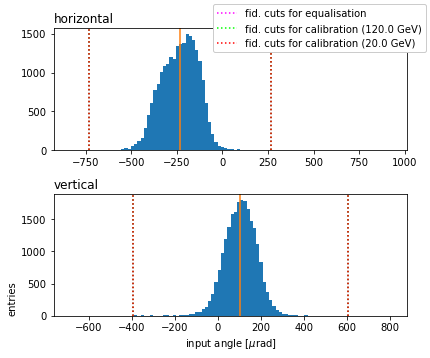

In [10]:
plt.close("input_angle")
fig = plt.figure("input_angle", figsize=(6, 5))

plt.subplot(211)
hist = plt.hist(df[b_run_tr&b_1hit&b_xgood].thIn0, bins=100);
ang_ave_x = np.average([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], weights=hist[0])
plt.axvline(ang_ave_x, c="C1")
plt.axvline(ang_ave_x-ang_cut_eq[0], c="magenta", ls=":", label="fid. cuts for equalisation")
plt.axvline(ang_ave_x+ang_cut_eq[0], c="magenta", ls=":")
plt.axvline(ang_ave_x-ang_cut_calib[np.max(list(runs_calib.keys()))][0], c="lime", ls=":", label="fid. cuts for calibration (%.1f GeV)" % np.max(list(runs_calib.keys())))
plt.axvline(ang_ave_x+ang_cut_calib[np.max(list(runs_calib.keys()))][0], c="lime", ls=":")
plt.axvline(ang_ave_x-ang_cut_calib[np.min(list(runs_calib.keys()))][0], c="red", ls=":", label="fid. cuts for calibration (%.1f GeV)" % np.min(list(runs_calib.keys())))
plt.axvline(ang_ave_x+ang_cut_calib[np.min(list(runs_calib.keys()))][0], c="red", ls=":")
plt.title("horizontal", loc="left")
print("horizontal centre = %f urad" % ang_ave_x)

plt.subplot(212)
hist = plt.hist(df[b_run_tr&b_1hit&b_xgood].thIn1, bins=100);
ang_ave_y = np.average([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], weights=hist[0])
plt.axvline(ang_ave_y, c="C1")
plt.axvline(ang_ave_y-ang_cut_eq[1], c="magenta", ls=":")
plt.axvline(ang_ave_y+ang_cut_eq[1], c="magenta", ls=":")
plt.axvline(ang_ave_y-ang_cut_calib[np.max(list(runs_calib.keys()))][1], c="lime", ls=":")
plt.axvline(ang_ave_y+ang_cut_calib[np.max(list(runs_calib.keys()))][1], c="lime", ls=":")
plt.axvline(ang_ave_y-ang_cut_calib[np.min(list(runs_calib.keys()))][1], c="red", ls=":")
plt.axvline(ang_ave_y+ang_cut_calib[np.min(list(runs_calib.keys()))][1], c="red", ls=":")
plt.title("vertical", loc="left")
print("vertical centre = %f urad" % ang_ave_y)

fig.legend(framealpha=1, loc="upper right")
plt.ylabel('entries', loc="bottom")
plt.xlabel(r"input angle [$\mu$rad]")
plt.tight_layout()

In [11]:
# creating booleans for cuts on angles here
b_angle_eq = (abs(df.thIn0-ang_ave_x) < ang_cut_eq[0]) & (abs(df.thIn1-ang_ave_y) < ang_cut_eq[1])
b_angle_calib = {}
for energy in runs_calib:
    b_angle_calib.update({energy: (abs(df.thIn0-ang_ave_x) < ang_cut_calib[energy][0]) & (abs(df.thIn1-ang_ave_y) < ang_cut_calib[energy][1])})

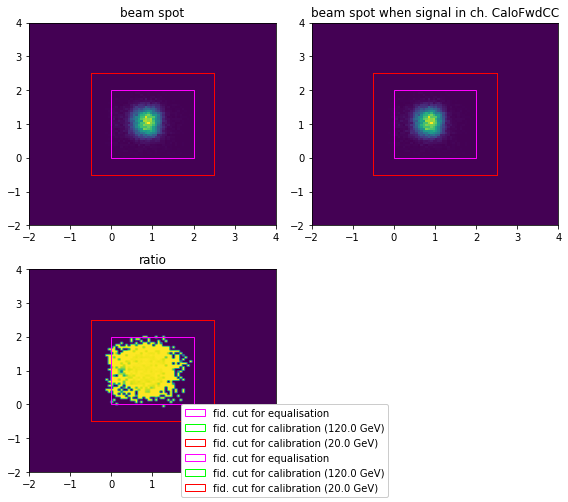

In [12]:
plt.close("profile_at_calo")
fig, ax = plt.subplots(num = "profile_at_calo", figsize=(8, 7), nrows=2, ncols=2)

b_ph_tr = (df[var_ph+ch_tracking[2]] > ch_tracking_thresh[0]) & (df[var_ph+ch_tracking[2]] < ch_tracking_thresh[1])

ax[0, 0].hist2d(df[b_angle_eq&b_run_tr&b_1hit].xCal0, df[b_angle_eq&b_run_tr&b_1hit].xCal1, range=xcalo_range, bins=100);
ax[0, 0].set_title("beam spot")
ax[0, 0].add_patch(patches.Rectangle(
    (fid_eq[0][0], fid_eq[1][0]), fid_eq[0][1]-fid_eq[0][0], fid_eq[1][1]-fid_eq[1][0],
    fill=False, edgecolor="magenta", label="fid. cut for equalisation"
))
ax[0, 0].add_patch(patches.Rectangle(
    (fid_calib[np.max(list(runs_calib.keys()))][0][0], fid_calib[np.max(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.max(list(runs_calib.keys()))][0][1] - fid_calib[np.max(list(runs_calib.keys()))][0][0], 
    fid_calib[np.max(list(runs_calib.keys()))][1][1] - fid_calib[np.max(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="lime", label="fid. cut for calibration (%.1f GeV)" % np.max(list(runs_calib.keys()))
))
ax[0, 0].add_patch(patches.Rectangle(
    (fid_calib[np.min(list(runs_calib.keys()))][0][0], fid_calib[np.min(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.min(list(runs_calib.keys()))][0][1] - fid_calib[np.min(list(runs_calib.keys()))][0][0], 
    fid_calib[np.min(list(runs_calib.keys()))][1][1] - fid_calib[np.min(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="red", label="fid. cut for calibration (%.1f GeV)" % np.min(list(runs_calib.keys()))
))

ax[0, 1].hist2d(df[b_angle_eq&b_run_tr&b_1hit&b_ph_tr].xCal0, df[b_angle_eq&b_run_tr&b_1hit&b_ph_tr].xCal1, range=xcalo_range, bins=100);
ax[0, 1].set_title("beam spot when signal in ch. %s" % ch_tracking[2])
ax[0, 1].add_patch(patches.Rectangle(
    (fid_eq[0][0], fid_eq[1][0]), fid_eq[0][1]-fid_eq[0][0], fid_eq[1][1]-fid_eq[1][0],
    fill=False, edgecolor="magenta", label="fid. cut for equalisation"
))
ax[0, 1].add_patch(patches.Rectangle(
    (fid_calib[np.max(list(runs_calib.keys()))][0][0], fid_calib[np.max(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.max(list(runs_calib.keys()))][0][1] - fid_calib[np.max(list(runs_calib.keys()))][0][0], 
    fid_calib[np.max(list(runs_calib.keys()))][1][1] - fid_calib[np.max(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="lime", label="fid. cut for calibration (%.1f GeV)" % np.max(list(runs_calib.keys()))
))
ax[0, 1].add_patch(patches.Rectangle(
    (fid_calib[np.min(list(runs_calib.keys()))][0][0], fid_calib[np.min(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.min(list(runs_calib.keys()))][0][1] - fid_calib[np.min(list(runs_calib.keys()))][0][0], 
    fid_calib[np.min(list(runs_calib.keys()))][1][1] - fid_calib[np.min(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="red", label="fid. cut for calibration (%.1f GeV)" % np.min(list(runs_calib.keys()))
))

sl.hist2dRatio(
    df[b_angle_eq&b_run_tr&b_1hit&b_ph_tr].xCal0, df[b_angle_eq&b_run_tr&b_1hit&b_ph_tr].xCal1,
    df[b_angle_eq&b_run_tr&b_1hit].xCal0, df[b_angle_eq&b_run_tr&b_1hit].xCal1,
    range=xcalo_range, bins=100, ax=ax[1, 0]
);
ax[1, 0].add_patch(patches.Rectangle((fid_eq[0][0], fid_eq[1][0]), fid_eq[0][1]-fid_eq[0][0], fid_eq[1][1]-fid_eq[1][0], fill=False, edgecolor="magenta"))
ax[1, 0].add_patch(patches.Rectangle(
    (fid_calib[np.max(list(runs_calib.keys()))][0][0], fid_calib[np.max(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.max(list(runs_calib.keys()))][0][1] - fid_calib[np.max(list(runs_calib.keys()))][0][0], 
    fid_calib[np.max(list(runs_calib.keys()))][1][1] - fid_calib[np.max(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="lime"
))
ax[1, 0].add_patch(patches.Rectangle(
    (fid_calib[np.min(list(runs_calib.keys()))][0][0], fid_calib[np.min(list(runs_calib.keys()))][1][0]), 
    fid_calib[np.min(list(runs_calib.keys()))][0][1] - fid_calib[np.min(list(runs_calib.keys()))][0][0], 
    fid_calib[np.min(list(runs_calib.keys()))][1][1] - fid_calib[np.min(list(runs_calib.keys()))][1][0], 
    fill=False, edgecolor="red"
))
ax[1, 0].set_title("ratio")

ax[1, 1].axis("off")
fig.legend(framealpha=1, loc="lower center")

fig.tight_layout()

### **full-detector beam profile (with relative shifts), dedicated settings here:**

In [13]:
b_plot = False  # plot this?
ch_tracking_thresh_large = (2000, 20000)  # threshold on PH to highlight calo. channel, for plots with full calo.
xcalo_range_large = ((-5, 5), (-5, 5))  # range of beam spot full-calo. 2d histograms, ((left, right), (lower, upper))
xcalo_shift = {  # shifts (relative to centre) for each channel, {ch: [hor, ver]}
    "CaloFwdCC" : [0.0, 0.0],
}
global_shift_texts = (0, 0)  # global shift to be applied to plotted ch. names, set it to off-range values for no text
# # # # # # # # # #

if b_plot:
    plt.close("profile_at_calo_full")
    fig, ax = plt.subplots(num = "profile_at_calo_full", figsize=(5, 5))

    for ich, ch in enumerate(ind_calo):
        b_run_tr_temp = df.iRun == runs_eq[ch]
        b_ph_tr_temp = (df[var_ph+ch] > ch_tracking_thresh_large[0]) & (df[var_ph+ch] < ch_tracking_thresh_large[1])
        if (ich==0):
            hist, xedges, yedges = np.histogram2d(  # x & y swapped for imshow
                df[b_angle_eq&b_run_tr_temp&b_1hit&b_ph_tr_temp].xCal1 + xcalo_shift[ch][1], 
                df[b_angle_eq&b_run_tr_temp&b_1hit&b_ph_tr_temp].xCal0 + xcalo_shift[ch][0], 
                range=xcalo_range_large, bins=100
            )
        else:
            hist_temp, _, _ = np.histogram2d(  # x & y swapped for imshow
                df[b_angle_eq&b_run_tr_temp&b_1hit&b_ph_tr_temp].xCal1 + xcalo_shift[ch][1], 
                df[b_angle_eq&b_run_tr_temp&b_1hit&b_ph_tr_temp].xCal0 + xcalo_shift[ch][0], 
                range=xcalo_range_large, bins=100
            )
            hist = hist + hist_temp
    ax.imshow(hist, interpolation='nearest', origin='lower', extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])

    for ich, ch in enumerate(ind_calo):
        ax.text(
            fid_eq[0][0] + xcalo_shift[ch][0]+0.5*(fid_eq[0][1]-fid_eq[0][0]) + global_shift_texts[0],
            fid_eq[1][0] + xcalo_shift[ch][1]+0.5*(fid_eq[1][1]-fid_eq[1][0]) + global_shift_texts[1],
            "%s" % ch, color="1", weight="black", fontsize="large", ha="center", va="center"
        )
        ax.add_patch(patches.Rectangle((
            fid_eq[0][0] + xcalo_shift[ch][0], fid_eq[1][0] + xcalo_shift[ch][1]),
            fid_eq[0][1]-fid_eq[0][0], fid_eq[1][1]-fid_eq[1][0],
            fill=False, edgecolor="magenta", label="fid. cuts for equalisation" if (ich==0) else None
        ))
    ax.add_patch(patches.Rectangle(
        (fid_calib[np.max(list(runs_calib.keys()))][0][0], fid_calib[np.max(list(runs_calib.keys()))][1][0]), 
        fid_calib[np.max(list(runs_calib.keys()))][0][1] - fid_calib[np.max(list(runs_calib.keys()))][0][0], 
        fid_calib[np.max(list(runs_calib.keys()))][1][1] - fid_calib[np.max(list(runs_calib.keys()))][1][0], 
        fill=False, edgecolor="lime", label="fid. cut for calibration (%.1f GeV)" % np.max(list(runs_calib.keys()))
    ))
    ax.add_patch(patches.Rectangle(
        (fid_calib[np.min(list(runs_calib.keys()))][0][0], fid_calib[np.min(list(runs_calib.keys()))][1][0]), 
        fid_calib[np.min(list(runs_calib.keys()))][0][1] - fid_calib[np.min(list(runs_calib.keys()))][0][0], 
        fid_calib[np.min(list(runs_calib.keys()))][1][1] - fid_calib[np.min(list(runs_calib.keys()))][1][0], 
        fill=False, edgecolor="red", label="fid. cut for calibration (%.1f GeV)" % np.min(list(runs_calib.keys()))
    ))
    fig.legend(framealpha=1, loc="upper right")

    fig.tight_layout()

---

## **timing**

In [14]:
# cuts on calo. channel time spectra
if runs_all[0] in digiTimeCut:
    for iCh in runs_eq:
        if iCh in digiTimeCut[runs_all[0]]:
            chMin = digiTimeCut[runs_all[0]][iCh][0]
            chMax = digiTimeCut[runs_all[0]][iCh][1]
            digiTimeCut[runs_all[0]].update({iCh: (chMin, chMax)})
        else:
            digiTimeCut[runs_all[0]].update({iCh: (-1, 513)})
else:
    for iCh in runs_eq:
        digiTimeCut[runs_all[0]].update({iCh: (-1, 513)})

cut_time = digiTimeCut[runs_all[0]]  # caeful, using cuts for first run opened
name_cal_temp = name_cal[0].upper() + name_cal[1:] if not boolTest else ""
cut_time = {s: cut_time[s] for s in cut_time.keys() if (name_cal_temp in s)}

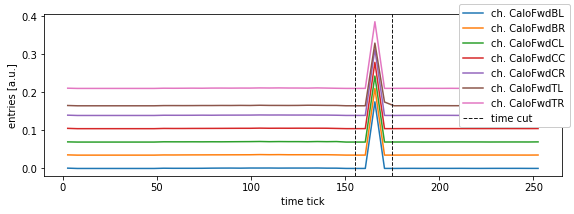

In [15]:
plt.close("time_spectra")
fig = plt.figure("time_spectra", figsize=(8, 3))

for ich, ch in enumerate(runs_eq):
    b_run_timing = df.iRun==runs_eq[ch]
    hist = np.histogram(df[b_run_timing][var_time+ch], bins=50, density=True)
    y_max = np.max(hist[0])
    plt.plot([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], np.array(hist[0])+(0.2*ich*y_max), label="ch. %s" % ch);
    
for icut, cut in enumerate(list(set(list(tuple(x) for x in cut_time.values())))):
    if len(list(set(list(tuple(x) for x in cut_time.values()))))==1:
        plt.axvline(cut[0], lw=1, ls="--", color=str(0.2*icut+0.1), label="time cut")
        plt.axvline(cut[1], lw=1, ls="--", color=str(0.2*icut+0.1))
    else:
        plt.axvline(cut[0], lw=1, ls="--", color=str(0.2*icut+0.1), label="time cut %d" % icut)
        plt.axvline(cut[1], lw=1, ls="--", color=str(0.2*icut+0.1))
    
plt.xlabel("time tick")
plt.ylabel("entries [a.u.]")
fig.legend(framealpha=1, loc="upper right")
plt.tight_layout()

---

## **equalisation**

### **general settings**

In [16]:
# ADC plot range per channel & nr. of ADC per bin (equalisation)
adc_range_eq = {
    "CaloFwdBL" : (100, 20000),
    "CaloFwdBR" : (100, 20000),
    "CaloFwdCL" : (100, 20000),
    "CaloFwdCC" : (100, 20000),
    "CaloFwdCR" : (100, 20000),
    "CaloFwdTL" : (100, 20000),
    "CaloFwdTR" : (100, 20000),
}
d_adc_eq = 100

# calo. ref. channel for equalisation
ch_ref_eq = "CaloFwdCC"

### **dataset** (```df_eq```) **creation & cleansing**

In [17]:
# data cleaning
b_runs_eq = False
for ch in runs_eq:
    b_runs_eq = b_runs_eq | (df.iRun==runs_eq[ch])
b_fid_eq = (df.xCal0>fid_eq[0][0]) & (df.xCal0<fid_eq[0][1]) & (df.xCal1>fid_eq[1][0]) & (df.xCal1<fid_eq[1][1])

df_eq = df[b_1hit&b_xgood&b_angle_eq&b_runs_eq&b_fid_eq]

### **raw spectra check, all channels for a specific run**
**(subject to boolean, settings below)**

In [18]:
b_plot = False  # plot this?
ch_ref_plot = "CaloFwdCC"  # choose run referred to a specific channel
# # # # # # # # # #

if b_plot:
    plt.close("ph_calo_centre_check_eq")
    plt.figure("ph_calo_centre_check_eq", figsize=(8, 3))

    for ich, ch in enumerate(ind_calo):
        bins_eq = np.arange(adc_range_eq[ch][0], adc_range_eq[ch][1], d_adc_eq)
        b_run_temp = df_eq.iRun==runs_eq[ch_ref_plot]
        b_time = (df_eq[var_time+ch]>cut_time[ch][0]) & (df_eq[var_time+ch]<cut_time[ch][1])
        hist = np.histogram(df_eq[b_run_temp&b_time][var_ph+ch], bins=bins_eq, density=True)
        y_max = max(hist[0])
        plt.plot([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], np.array(hist[0]), label="ch. %s" % ch);
        plt.xlabel("PH [ADC]")
        plt.ylabel("entries [a.u.]")
            
    plt.legend(framealpha=1, loc="upper right")
    plt.tight_layout()

### **single-channel, single energy spectra**
**(plots can be drawn upon request, settings below)**

In [19]:
b_plot = False  # draw the sample plot?
ch_plot = "CaloFwdCC"  # choose channel for the plot
# # # # # # # # # #

f_fit = sl.fGaus  # function for peak fit -- e.g. sl.fGaus, sl.fLandau

mpv_eq = {}

for ch in runs_eq:
    b_time = (df_eq[var_time+ch]>cut_time[ch][0]) & (df_eq[var_time+ch]<cut_time[ch][1])
    
    bins_eq = np.arange(adc_range_eq[ch][0], adc_range_eq[ch][1], d_adc_eq)
    
    b_run_temp = df_eq.iRun==runs_eq[ch]
    hist = np.histogram(df_eq[b_run_temp&b_time][var_ph+ch], bins=bins_eq)

    ifwhm0 = np.argmax(hist[0]>=0.5*np.max(hist[0]))
    fwhm0 = hist[1][ifwhm0]
    ifwhm1 = ifwhm0 + np.argmax(hist[0][ifwhm0:]<=0.5*np.max(hist[0]))
    fwhm1 = hist[1][ifwhm1]
    par0 = (np.max(hist[0]), hist[1][np.argmax(hist[0]==np.max(hist[0]))], np.max((fwhm1-fwhm0, abs(hist[1][1]-hist[1][0]))))
    imin = np.argmax(hist[0]>0.1*np.max(hist[0]))
    x_fit = [hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)][imin:]
    y_fit = hist[0][imin:]
    errMsg = ""
    try:
        par, _ = curve_fit(f_fit, x_fit, y_fit, p0=par0)
    except:
        errMsg = " --> fit failed!"
        par = par0

    if (b_plot & (ch==ch_plot)):
        plt.close("example_raw_spectrum")
        plt.figure("example_raw_spectrum")
        plt.plot([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], hist[0]);
        plt.plot(np.linspace(adc_range_eq[ch][0], adc_range_eq[ch][1], 1000), f_fit(np.linspace(adc_range_eq[ch][0], adc_range_eq[ch][1], 1000), *par))
        plt.xlabel("PH [ADC]")
        plt.ylabel("entries")
        plt.title("selected MIPs from ch. %s" % ch_plot)

    mpv_eq.update({ch: par[1]})
    print("ch. %2s: PH MPV = %f%s" % (ch, mpv_eq[ch], errMsg))

ch. CaloFwdBL: PH MPV = 3437.966343
ch. CaloFwdBR: PH MPV = 6606.795045
ch. CaloFwdCL: PH MPV = 9194.030872
ch. CaloFwdCC: PH MPV = 5548.335989
ch. CaloFwdCR: PH MPV = 5842.406750
ch. CaloFwdTL: PH MPV = 7507.335176
ch. CaloFwdTR: PH MPV = 5910.350418


### **equalisation parameters** &mdash; in ```eq_par```

In [20]:
eq_par = {}

for ch in runs_eq:
    eq_par.update({ch: mpv_eq[ch_ref_eq]/mpv_eq[ch]})
    print("equalisation factor for ch. %2s = %f" % (ch, eq_par[ch]))

equalisation factor for ch. CaloFwdBL = 1.613842
equalisation factor for ch. CaloFwdBR = 0.839792
equalisation factor for ch. CaloFwdCL = 0.603472
equalisation factor for ch. CaloFwdCC = 1.000000
equalisation factor for ch. CaloFwdCR = 0.949666
equalisation factor for ch. CaloFwdTL = 0.739055
equalisation factor for ch. CaloFwdTR = 0.938749


### **equalised spectra check, each channel from his run**

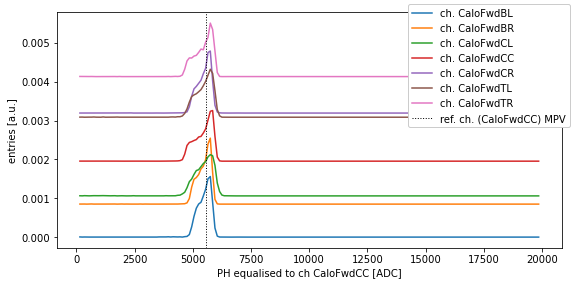

In [21]:
plt.close("ph_spectra_equalised")
fig = plt.figure("ph_spectra_equalised", figsize=(8, 4))

for ich, ch in enumerate(runs_eq):
    b_run_temp = df_eq.iRun==runs_eq[ch]
    b_time = (df_eq[var_time+ch]>cut_time[ch][0]) & (df_eq[var_time+ch]<cut_time[ch][1])
    hist = np.histogram(eq_par[ch]*df_eq[b_run_temp&b_time][var_ph+ch], bins=bins_eq, density=True)
    y_max = max(hist[0])
    plt.plot([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], np.array(hist[0])+0.5*ich*y_max, label="ch. %s" % ch);
    plt.xlabel("PH equalised to ch %s [ADC]" % ch_ref_eq)
    plt.ylabel("entries [a.u.]")
    
plt.axvline(mpv_eq[ch_ref_eq], c="k", ls=":", lw=1, label="ref. ch. (%s) MPV" % ch_ref_eq)
fig.legend(framealpha=1, loc="upper right")
plt.tight_layout()

---

## **calibration**

### **general settings**

In [22]:
# range for ADC value plots ((min, max)) & nr. of ADC per bin (calibration)
adc_range_calib = (-100, 20000)
d_adc_calib = 20

### **dataset** (```df_calib```) **creation & cleansing**

In [23]:
# data cleaning...
df_calib = pd.DataFrame()
for energy in runs_calib:
    b_runs_calib_temp = df.iRun==runs_calib[energy]
    b_fid_calib_temp = (df.xCal0>fid_calib[energy][0][0]) & (df.xCal0<fid_calib[energy][0][1]) & (df.xCal1>fid_calib[energy][1][0]) & (df.xCal1<fid_calib[energy][1][1])
    
    df_calib = df_calib.append(df[b_1hit&b_xgood&b_angle_calib[energy]&b_runs_calib_temp&b_fid_calib_temp], sort=False)

# ... and new variables
b_time_tot = False
for ch in ind_calo:
    b_time_temp = (df_calib[var_time+ch]>cut_time[ch][0]) & (df_calib[var_time+ch]<cut_time[ch][1])
    b_time_tot = b_time_tot | b_time_temp
    
for ich, ch in enumerate(ind_calo):
    df_calib[var_ph+ch+"_eq"] = eq_par[ch]*df_calib[var_ph+ch]
    if ich==0:
        df_calib.loc[b_time_tot, "ph_tot"] = df_calib[var_ph+ch+"_eq"]
    else:
        df_calib.loc[b_time_tot, "ph_tot"] = df_calib["ph_tot"] + df_calib[var_ph+ch+"_eq"]
        
# also, creating bin array  
bins_calib = np.arange(adc_range_calib[0], adc_range_calib[1], d_adc_calib)

### **equalised spectra check with calibration data**
**(subject to boolean, settings below)**

In [24]:
b_plot = False  # plot this?
energy_plot = 120  # choose energy
# # # # # # # # # #

if b_plot:
    plt.close("ph_calo_centre_check_calib")
    plt.figure("ph_calo_centre_check_calib", figsize=(8, 3))

    for ich, ch in enumerate(ind_calo):
        b_run_temp = df_calib.iRun==runs_calib[energy_plot]
        b_time = (df_calib[var_time+ch]>cut_time[ch][0]) & (df_calib[var_time+ch]<cut_time[ch][1])
        hist = np.histogram(df_calib[b_run_temp&b_time][var_ph+ch+"_eq"], bins=bins_calib, density=True)
        y_max = max(hist[0])
        plt.plot([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], np.array(hist[0]), label="ch. %s" % ch);
        plt.xlabel("PH [ADC]")
        plt.ylabel("entries [a.u.]")
            
    plt.legend(framealpha=1, loc="upper right")
    plt.tight_layout()

### **total PH spectra at different energies**
**(some settings below)**

@ 120 GeV, PH MPV (width) = 12308.858510 (181.129326)
@ 100 GeV, PH MPV (width) = 9889.097023 (171.201486)
@  80 GeV, PH MPV (width) = 8018.420434 (138.151134)
@  60 GeV, PH MPV (width) = 6349.049815 (160.140852)
@  20 GeV, PH MPV (width) = 2021.375116 (135.534268)


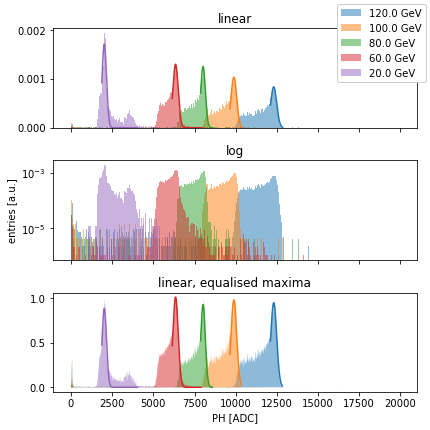

In [25]:
frac_height_fit = (0.60, 0)  # fraction of spectrum maximum height above which to start [0] and stop [1] the fit
f_fit = sl.fGaus  # function for peak fit -- e.g. sl.fGaus, sl.fLandau
# # # # # # # # # #

plt.close("ph_tot_all")
fig, ax = plt.subplots(num="ph_tot_all", nrows=3, ncols=1, figsize=(6, 6), sharex=True)

ymax = []
mpv_calib = {}
wdt_calib = {}

for ienergy, energy in enumerate(runs_calib):
    b_run_temp = df_calib.iRun == runs_calib[energy]
    
    hist = ax[0].hist(df_calib[b_run_temp].ph_tot, bins=bins_calib, color="C%d" % ienergy, density=True, alpha=0.5, label="%.1f GeV" % energy)
    ymax.append(np.max(hist[0]))
    ifwhm0 = np.argmax(hist[0]>=0.5*ymax[ienergy])
    fwhm0 = hist[1][ifwhm0]
    imax = np.argmax(hist[0]==ymax[ienergy])
    ifwhm1 = imax + np.argmax(hist[0][imax:]<=0.5*ymax[ienergy])
    fwhm1 = hist[1][ifwhm1]
    par0 = (ymax[ienergy], hist[1][np.argmax(hist[0]==ymax[ienergy])], np.max((fwhm1-fwhm0, abs(hist[1][1]-hist[1][0]))))
    ifitmin = np.argmax(hist[0]>=frac_height_fit[0]*ymax[ienergy])
    ifitmax = imax + np.argmax(hist[0][imax:]<=frac_height_fit[1]*ymax[ienergy])
    x_fit = [hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)][ifitmin:ifitmax]
    y_fit = hist[0][ifitmin:ifitmax]
    errMsg = ""
    try:
        par, _ = curve_fit(f_fit, x_fit, y_fit, p0=par0)
        x_plot_fit = np.linspace(np.min(x_fit), np.max(x_fit), 500)
    except:
        errMsg = " --> fit (& plot) failed!"
        x_plot_fit = np.linspace(0, 1, 100)
        par = par0
    ax[0].plot(x_plot_fit, f_fit(x_plot_fit, *par))
    ax[0].set_title("linear")

    ax[1].hist(df_calib[b_run_temp].ph_tot, bins=bins_calib, color="C%d" % ienergy, density=True, alpha=0.5);
    ax[1].set_yscale("log")
    ax[1].set_title("log")
    ax[1].set_ylabel("entries [a.u.]")

    ax[2].fill([hist[1][i]+0.5*(hist[1][i+1]-hist[1][i]) for i in range(len(hist[1])-1)], hist[0]*(1/ymax[ienergy]), alpha=0.5)
    ax[2].plot(x_plot_fit, f_fit(x_plot_fit, *par)*(1/ymax[ienergy]))
    ax[2].set_title("linear, equalised maxima")
    ax[2].set_xlabel("PH [ADC]")
    
    mpv_calib.update({energy: par[1]})
    wdt_calib.update({energy: par[2]})
    print("@ %3d GeV, PH MPV (width) = %f (%f)%s" % (energy, mpv_calib[energy], wdt_calib[energy], errMsg))
    
fig.legend(framealpha=1, loc="upper right")
fig.tight_layout()

### **calibration & energy resolution**

LINEARITY plot fitted w/ 1-degree polynomial:
GeV =
 
0.009903 ADC - 0.4257


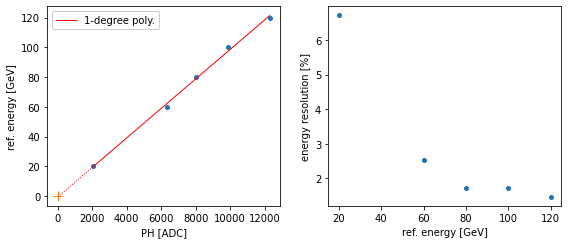

In [29]:
lin_fit_deg = 1  # linearity fit polynomial degree
b_res_fit = False  # if True (False), energy resolution is fitted
b_res_include_electronic = True  # if True (False), include electronic term to resolution
# # # # # # # # # #

plt.close("calibration")
fig, ax = plt.subplots(num="calibration", nrows=1, ncols=2, figsize=(8, 3.5))

# linearity
x, y = list(mpv_calib.values()), list(mpv_calib.keys())
ax[0].plot(x, y, lw=0, marker="o", ms=4)
ax[0].plot([0], [0], lw=0, marker="+", ms=10)
ax[0].set_xlabel("PH [ADC]")
ax[0].set_ylabel("ref. energy [GeV]")

par = np.polyfit(x, y, lin_fit_deg)
poly = np.poly1d(par, variable="ADC")
x_plot_fit = np.linspace(np.min(x), np.max(x), 100)
ax[0].plot(x_plot_fit, poly(x_plot_fit), label = "%d-degree poly." % lin_fit_deg, lw=1, c="r")
ax[0].plot(np.linspace(0, np.min(x), 100), poly(np.linspace(0, np.min(x), 100)), lw=1, c="r", ls=":")
print("LINEARITY plot fitted w/ %d-degree polynomial:" % lin_fit_deg)
print("GeV =")
print(poly)

ax[0].legend(loc="upper left", framealpha=1)

# energy resolution
x, y = list(mpv_calib.keys()), np.array([abs(wdt)/mpv for wdt, mpv in zip(wdt_calib.values(), mpv_calib.values())]) * 100  # converted into %
ax[1].plot(x, y, lw=0, marker="o", ms=4)
ax[1].set_xlabel("ref. energy [GeV]")
ax[1].set_ylabel("energy resolution [%]")

if b_res_fit:
    if b_res_include_electronic:
        f_res = lambda x, a, b, c : np.sqrt( (a/np.sqrt(x))**2 + (b/x)**2 + c**2 )
        par, _ = curve_fit(f_res, x, y, p0=(1, 1, 1), bounds=((0, 0, 0), (100, 100, 100)))
        x_plot_fit = np.linspace(np.min(x), np.max(x), 100)
        ax[1].plot(x_plot_fit, f_res(x_plot_fit, *par), lw=1, c="r", label="stochastic + constant")
        print("\nRESOLUTION plot fitted w/ stochastic, electronic & constant term")
        print("a = %e" % par[0])
        print("b = %e" % par[1])
        print("c = %e" % par[2])
    else:
        f_res = lambda x, a, c : np.sqrt( (a/np.sqrt(x))**2 + c**2 )
        par, _ = curve_fit(f_res, x, y, p0=(1, 1), bounds=((0, 0), (100, 100)))
        x_plot_fit = np.linspace(np.min(x), np.max(x), 100)
        ax[1].plot(x_plot_fit, f_res(x_plot_fit, *par), lw=1, c="r", label="stochastic + constant")
        print("\nRESOLUTION plot fitted w/ stochastic & constant term")
        print("a = %e" % par[0])
        print("c = %e" % par[1])
    
    ax[1].legend(loc="upper right", framealpha=1)

fig.tight_layout()

---

## **whiteboard**